In [94]:
import os
import opendatasets as od
import pandas as pd

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [95]:
od.download("https://www.kaggle.com/c/rossmann-store-sales", "../data")

Skipping, found downloaded files in "../data/rossmann-store-sales" (use force=True to force download)


In [96]:
os.listdir("../data/rossmann-store-sales")

['test.csv', 'train.csv', 'store.csv', 'sample_submission.csv']

In [97]:
ross_df = pd.read_csv("../data/rossmann-store-sales/train.csv", low_memory=False)
store_df = pd.read_csv("../data/rossmann-store-sales/store.csv")
test_df = pd.read_csv("../data/rossmann-store-sales/test.csv")
submission_df = pd.read_csv("../data/rossmann-store-sales/sample_submission.csv")

In [98]:
ross_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [99]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [100]:
submission_df.head(),

(   Id  Sales
 0   1      0
 1   2      0
 2   3      0
 3   4      0
 4   5      0,)

# Feature Engineering

In this notebook, we will create new features from the existing ones. We will also remove some features that are not useful for the model.

In [101]:
# Merge the information from the store dataset into the training and test datasets
merged_df = ross_df.merge(store_df, how="left", on="Store")
merged_test_df = test_df.merge(store_df, how="left", on="Store")
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Date

Convert `Date` to a `datecolumn` and extract different features from it.

In [102]:
def split_date(df: pd.DataFrame) -> None:
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["WeekOfYear"] = df["Date"].dt.isocalendar().week

In [103]:
split_date(merged_df)
split_date(merged_test_df)

In [104]:
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


## Store Open/Closed

The sales are zero when the store is closed. We can use this information to create a new feature `closed` which is `1` when the store is closed and `0` when the store is open.

In [105]:
merged_df[merged_df["Open"] == 0]["Sales"].value_counts()

Sales
0    172817
Name: count, dtype: int64

In [106]:
# Instead of trying to predict the sales when the store is closed, we will remove those rows from the training dataset and hardcode the predictions to 0 in the test dataset.
merged_df = merged_df[merged_df["Open"] == 1].copy()

## Competition

We can use the columns `CompetitionOpenSince[Month/Year]` to compute the number of months since the competition opened.

In [107]:
def comp_months(df):
    df["CompetitionOpen"] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (
        df.Month - df.CompetitionOpenSinceMonth
    )
    df["CompetitionOpen"] = (
        df["CompetitionOpen"].apply(lambda x: x if x > 0 else 0).fillna(0)
    )

In [108]:
comp_months(merged_df)
comp_months(merged_test_df)

In [109]:
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0


In [110]:
# View the results of the new feature created
merged_df[
    ["Date", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "CompetitionOpen"]
].sample(5)

,Date,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionOpen
155078,2015-03-14,NaN,NaN,0.0
367813,2014-08-13,NaN,NaN,0.0
399196,2014-07-10,2.0,2011.0,41.0
843977,2013-06-05,10.0,2009.0,44.0
951552,2013-02-28,NaN,NaN,0.0


## Additional Promotion

Add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.

In [111]:
def check_promo_month(row):
    month2str = {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec",
    }
    try:
        months = row.PromoInterval.split(",")
        if row["Promo2Open"] and month2str[row.Month] in months:
            return 1
        return 0
    except AttributeError:
        return 0


def promo_cols(df):
    # Months since Promo2 was open
    df["Promo2Open"] = (
        12 * (df.Year - df.Promo2SinceYear)
        + (df.WeekOfYear - df.Promo2SinceWeek) * 7 / 30
    )
    df["Promo2Open"] = (
        df["Promo2Open"].apply(lambda x: x if x > 0 else 0).fillna(0) * df["Promo2"]
    )
    # Check if the month is in the PromoInterval
    df["IsPromo2Month"] = df.apply(check_promo_month, axis=1) * df["Promo2"]

In [112]:
promo_cols(merged_df)
promo_cols(merged_test_df)

In [113]:
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.200000,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,51.966667,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0,0.000000,0


# Input and Target Columns

Select the columns that will be used as input for the model and the target column.

In [114]:
merged_df.columns.to_list()

['Store',
 'DayOfWeek',
 'Date',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'Year',
 'Month',
 'Day',
 'WeekOfYear',
 'CompetitionOpen',
 'Promo2Open',
 'IsPromo2Month']

In [115]:
input_cols = [
    "Store",
    "DayOfWeek",
    "Promo",
    "StateHoliday",
    "SchoolHoliday",
    "StoreType",
    "Assortment",
    "CompetitionDistance",
    "CompetitionOpen",
    "Day",
    "Month",
    "Year",
    "WeekOfYear",
    "Promo2",
    "Promo2Open",
    "IsPromo2Month",
]
target_col = "Sales"

In [116]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [117]:
test_inputs = merged_test_df[input_cols].copy()

In [118]:
inputs.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,5,1,0,1,c,a,1270.0,82.0,31,7,2015,31,0,0.000000,0
1,2,5,1,0,1,a,a,570.0,92.0,31,7,2015,31,1,64.200000,1
2,3,5,1,0,1,a,a,14130.0,103.0,31,7,2015,31,1,51.966667,1
3,4,5,1,0,1,c,c,620.0,70.0,31,7,2015,31,0,0.000000,0
4,5,5,1,0,1,a,a,29910.0,3.0,31,7,2015,31,0,0.000000,0


In [119]:
targets.head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [120]:
# Check if the number of columns in the training and test datasets are the same
len(inputs.columns) == len(test_inputs.columns)

True

Identify numerical and categorical columns. Note that we can treat binary columns as numerical columns.

In [121]:
numeric_cols = inputs.select_dtypes(include=["int64", "float64"]).columns.to_list()
numeric_cols.remove("DayOfWeek")
categorical_cols = inputs.select_dtypes(include=["object"]).columns.to_list() + [
    "DayOfWeek"
]

numeric_cols, categorical_cols

(['Store',
  'Promo',
  'SchoolHoliday',
  'CompetitionDistance',
  'CompetitionOpen',
  'Promo2',
  'Promo2Open',
  'IsPromo2Month'],
 ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek'])

## Impute missing numerical data

In [122]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
dtype: int64

In [123]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
dtype: int64

Seems like competition distance has some missing values. We will impute these missing values with the highest distance (to indicate that the store is far away from the competition).

In [124]:
max_distance = inputs["CompetitionDistance"].max()
max_distance

75860.0

In [125]:
inputs.fillna({"CompetitionDistance": max_distance}, inplace=True)
test_inputs.fillna({"CompetitionDistance": max_distance}, inplace=True)

## Scale Numerical Data

Scale the numerical data to the range `[0, 1]`.

In [126]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [127]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

## Encode Categorical Data

Encode the categorical data using one-hot encoding.

In [128]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown="ignore").fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
encoded_cols == list(encoder.get_feature_names_out())

True

In [129]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols]).toarray()
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols]).toarray()

In [130]:
# Extract all the numerical columns for training and testing
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

We haven't created a validation set yet, because we will use K-Fold Cross Validation to evaluate the model.

## Training

To train a GBM, we can use the `XGBRegressor` from the `xgboost` library.

In [131]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=20,
    max_depth=4,
    learning_rate=0.1,
    n_jobs=-1,
    verbosity=1,
)

model.fit(X, targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [132]:
preds = model.predict(X)
preds[:10]

array([7536.035 , 7103.2646, 7750.102 , 8165.821 , 7449.123 , 7994.002 ,
       7912.331 , 7523.7827, 7912.331 , 7523.7827], dtype=float32)

In [133]:
# Evaluate the model using the RMSE error metric
from sklearn.metrics import root_mean_squared_error


def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

In [134]:
rmse(targets, preds)

2651.4080422039438

In [135]:
merged_df["Sales"].min(), merged_df["Sales"].max()

(0, 41551)

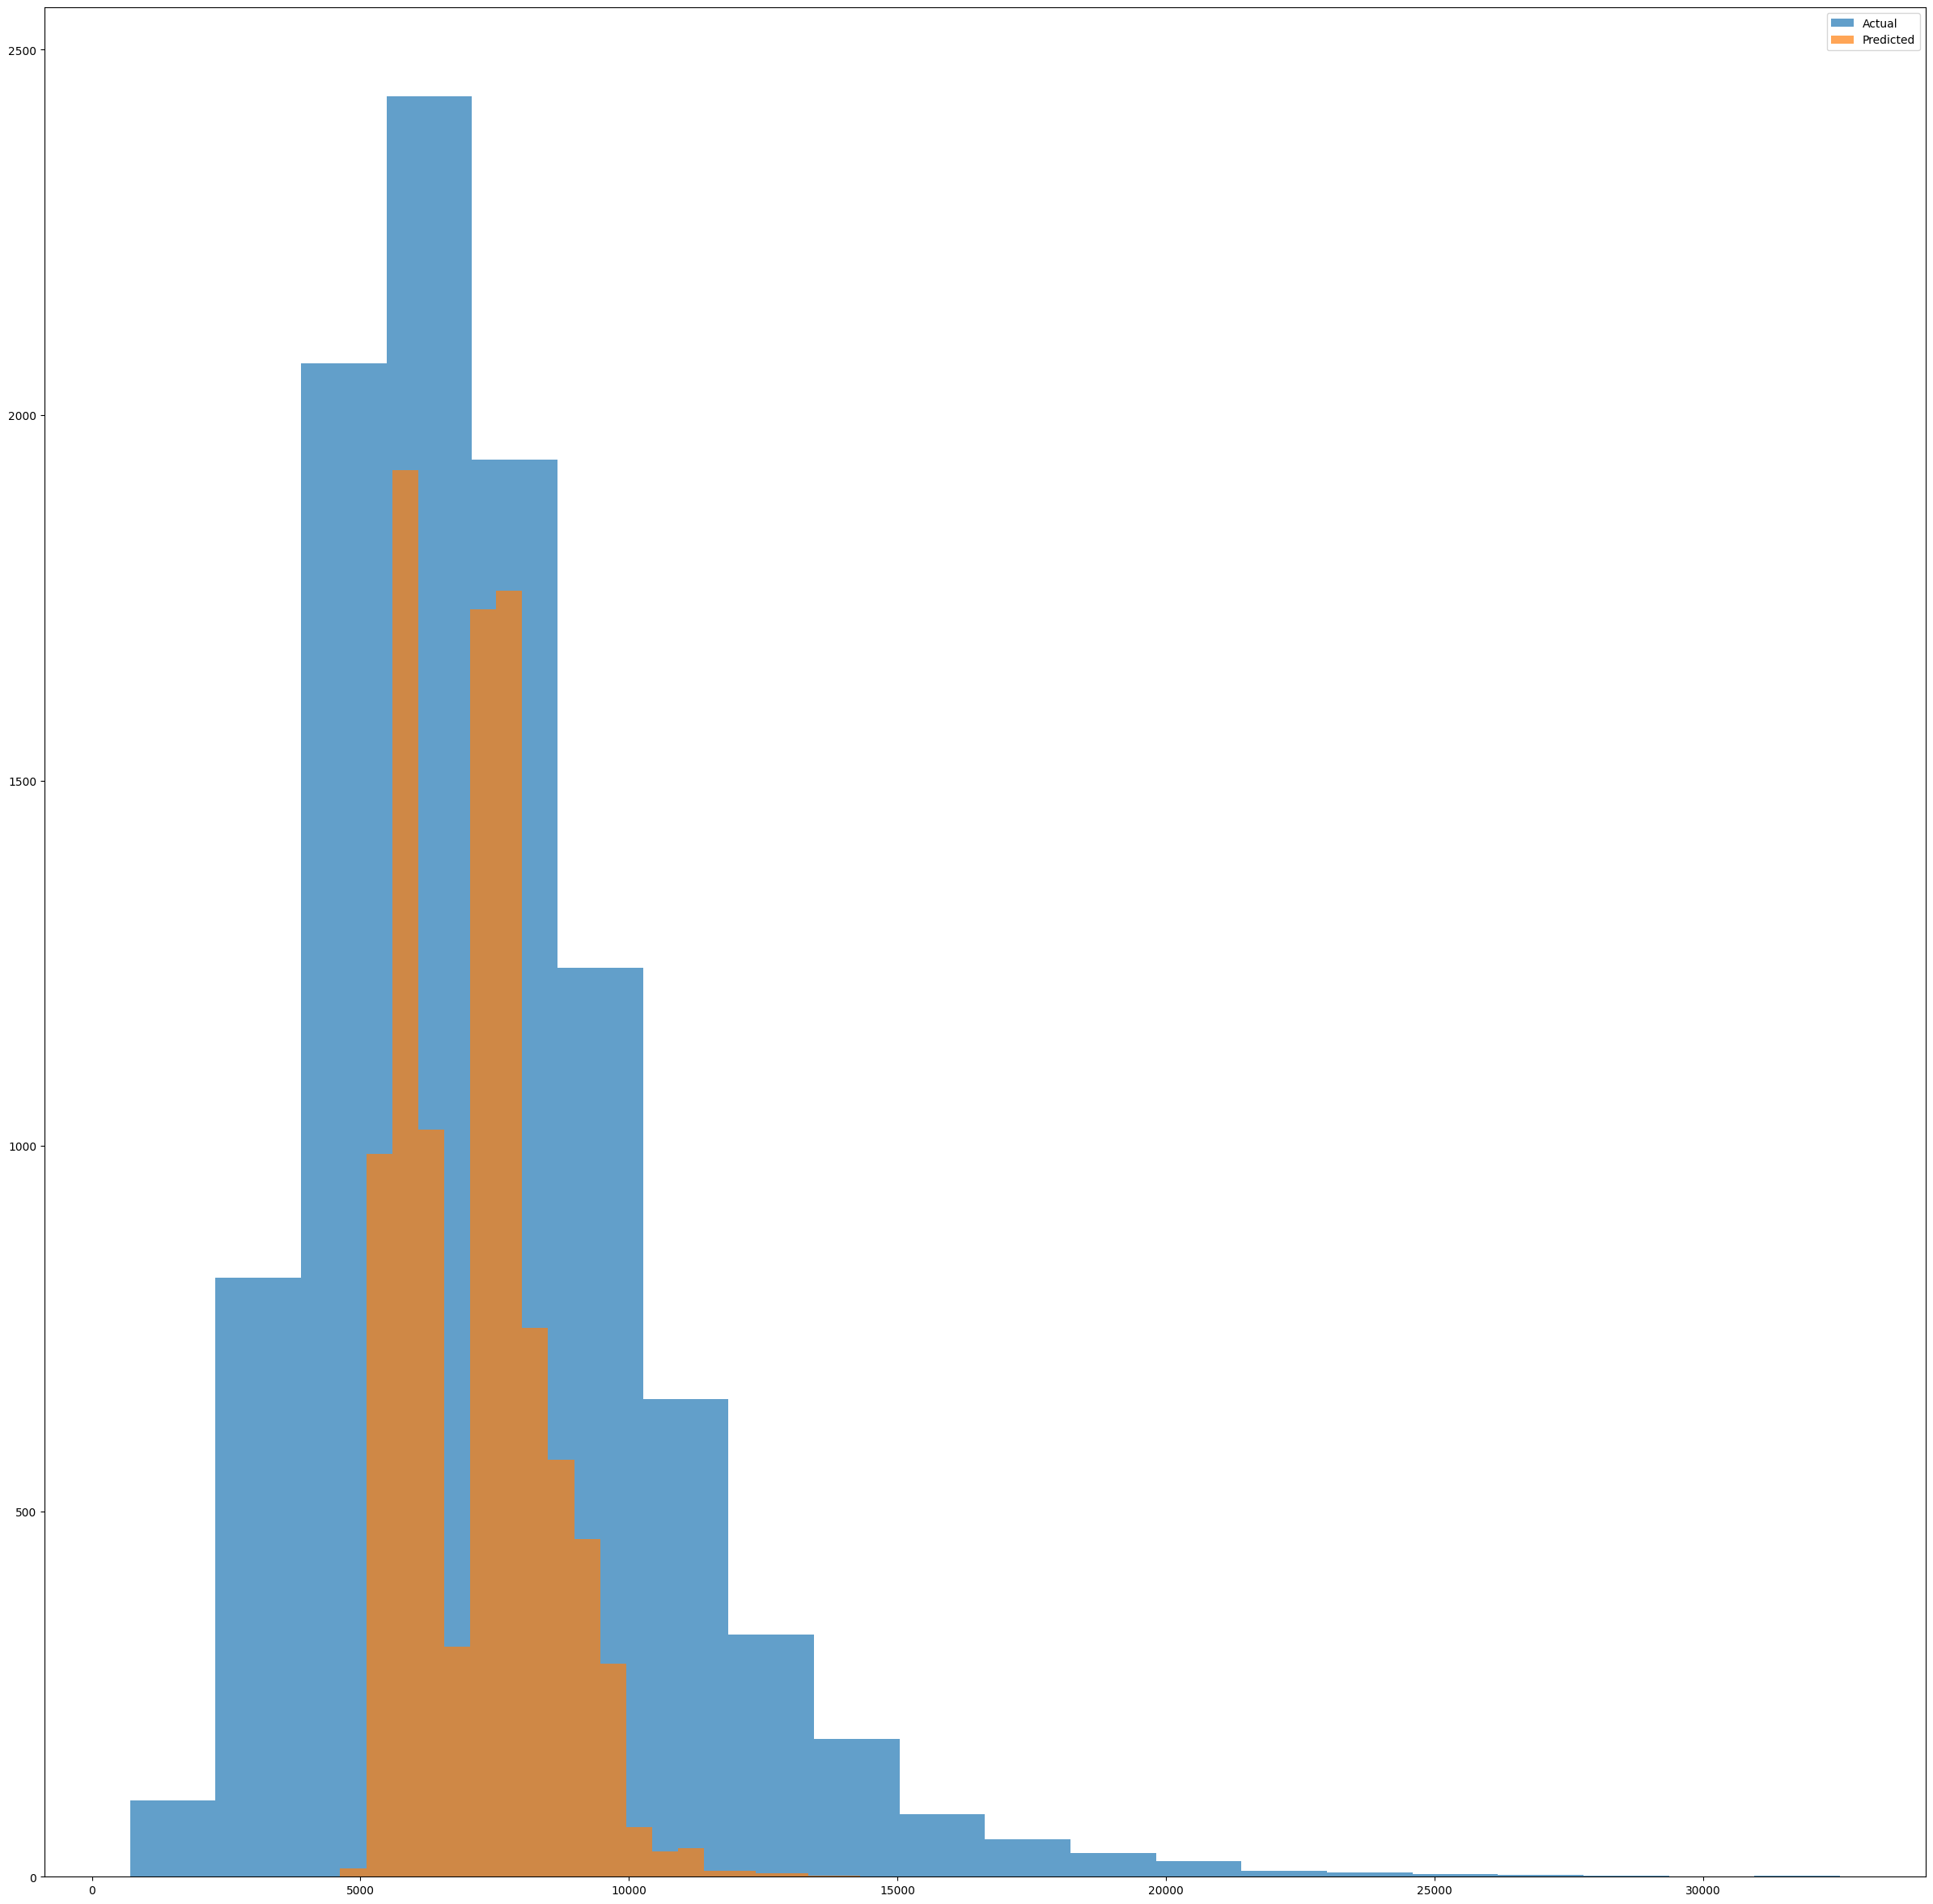

In [136]:
import matplotlib.pyplot as plt

plt.hist(merged_df.Sales[:10000], bins=20, alpha=0.7, label="Actual")
plt.hist(preds[:10000], bins=20, alpha=0.7, label="Predicted")
plt.legend()
plt.show()

## Visualizations

Using `plot_tree` from `xgboost` to visualize the decision trees.

In [137]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams  # to set figure size

rcParams["figure.figsize"] = 30, 30

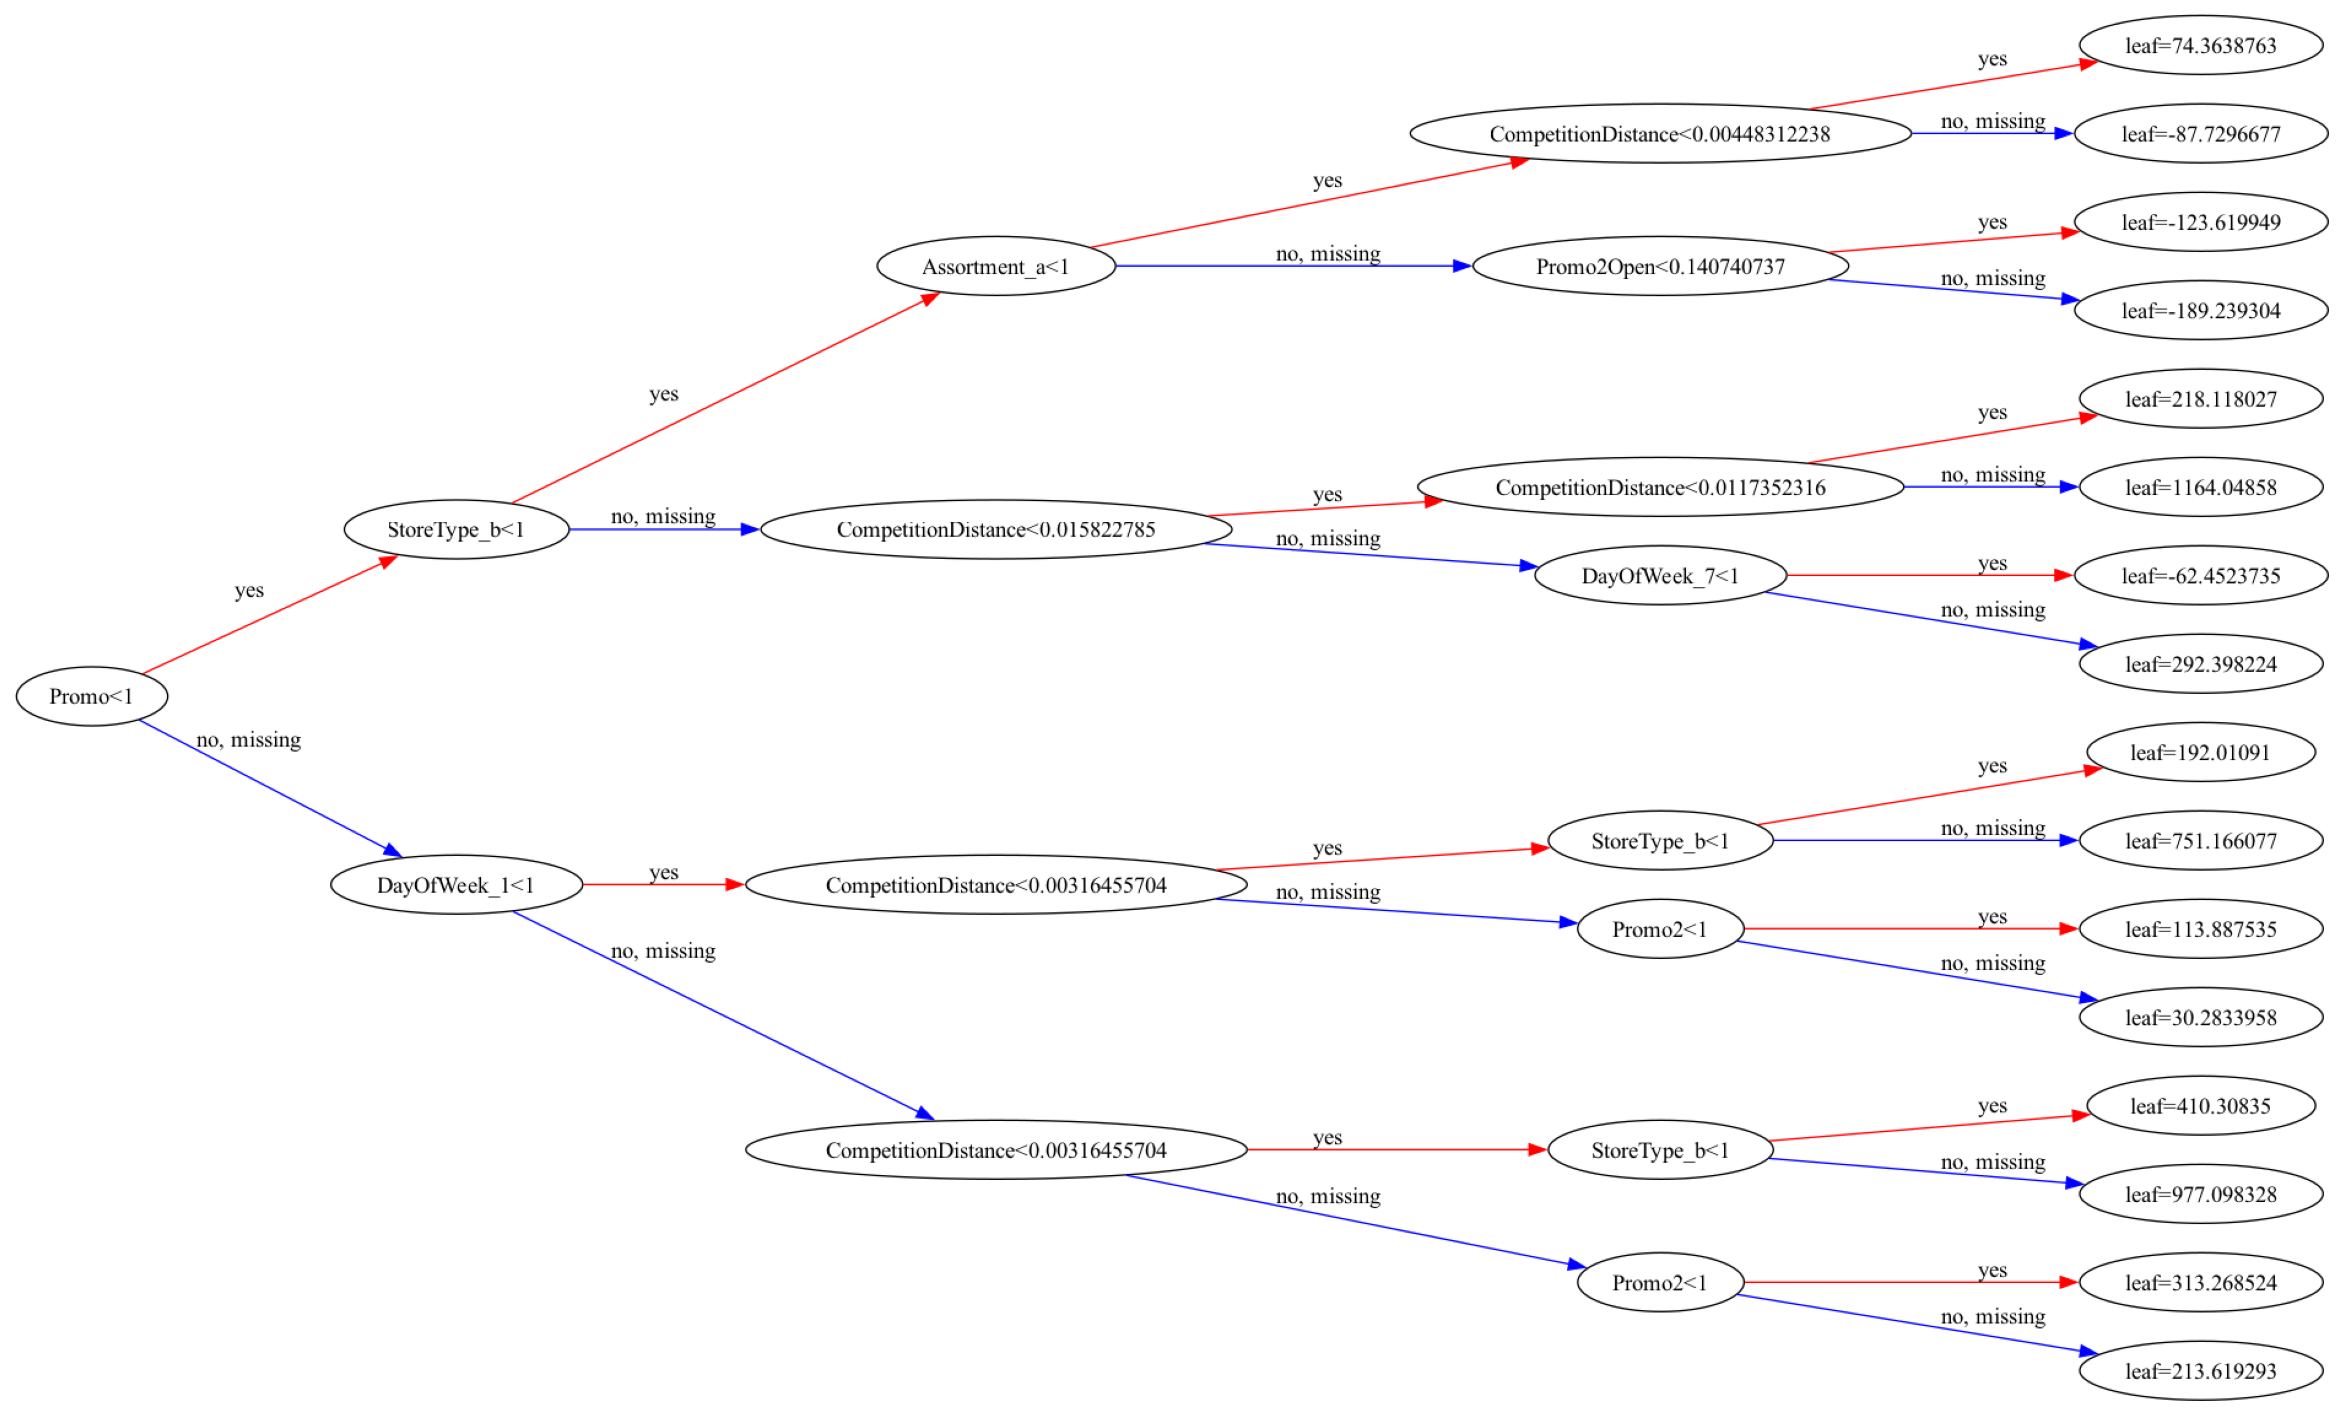

In [138]:
plot_tree(model, rankdir="LR", num_trees=0)
plt.show()

In [139]:
trees = model.get_booster().get_dump()
len(trees)

20

In [140]:
print(trees[0])

0:[Promo<1] yes=1,no=2,missing=2
	1:[StoreType_b<1] yes=3,no=4,missing=4
		3:[Assortment_a<1] yes=7,no=8,missing=8
			7:[CompetitionDistance<0.00448312238] yes=15,no=16,missing=16
				15:leaf=74.3638763
				16:leaf=-87.7296677
			8:[Promo2Open<0.140740737] yes=17,no=18,missing=18
				17:leaf=-123.619949
				18:leaf=-189.239304
		4:[CompetitionDistance<0.015822785] yes=9,no=10,missing=10
			9:[CompetitionDistance<0.0117352316] yes=19,no=20,missing=20
				19:leaf=218.118027
				20:leaf=1164.04858
			10:[DayOfWeek_7<1] yes=21,no=22,missing=22
				21:leaf=-62.4523735
				22:leaf=292.398224
	2:[DayOfWeek_1<1] yes=5,no=6,missing=6
		5:[CompetitionDistance<0.00316455704] yes=11,no=12,missing=12
			11:[StoreType_b<1] yes=23,no=24,missing=24
				23:leaf=192.01091
				24:leaf=751.166077
			12:[Promo2<1] yes=25,no=26,missing=26
				25:leaf=113.887535
				26:leaf=30.2833958
		6:[CompetitionDistance<0.00316455704] yes=13,no=14,missing=14
			13:[StoreType_b<1] yes=27,no=28,missing=28
				27:leaf=410

## Feature importance

Just like decision trees and random forests, we can use the `feature_importances_` attribute of the model to get the importance of each feature.

In [141]:
importance_df = pd.DataFrame(
    {"feature": X.columns, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

importance_df.head()

,feature,importance
1,Promo,0.520713
19,DayOfWeek_1,0.127084
13,StoreType_b,0.054854
16,Assortment_a,0.046311
5,Promo2,0.034908


<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

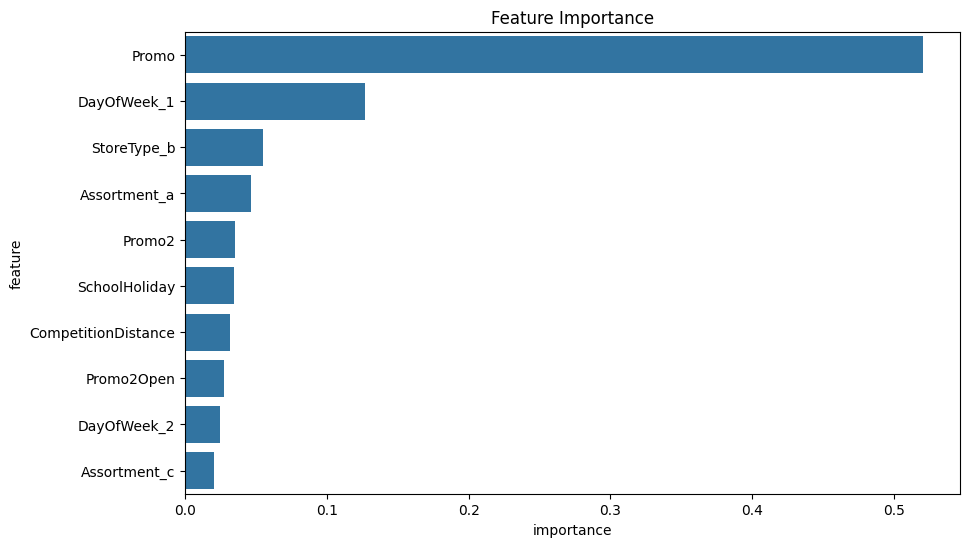

In [142]:
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
sns.barplot(data=importance_df.head(10), x="importance", y="feature")

## K-Fold Cross Validation

We will use K-Fold Cross Validation to evaluate the model.

In [143]:
from sklearn.model_selection import KFold

In [144]:
def train_and_eval(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rsme = rmse(train_targets, model.predict(X_train))
    val_rsme = rmse(val_targets, model.predict(X_val))
    return model, train_rsme, val_rsme

In [145]:
kfold = KFold(n_splits=5, shuffle=True)

In [146]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rsme, val_rsme = train_and_eval(
        X_train,
        train_targets,
        X_val,
        val_targets,
        n_estimators=20,
        max_depth=4,
        learning_rate=0.1,
    )
    print("Train RMSE:", train_rsme, "Val RMSE:", val_rsme)
    models.append(model)

Train RMSE: 2652.807105180025 Val RMSE: 2656.800384595211
Train RMSE: 2651.540158009269 Val RMSE: 2642.4906464966566
Train RMSE: 2656.4369287388317 Val RMSE: 2655.389055611247
Train RMSE: 2652.3143847438514 Val RMSE: 2659.545473047431
Train RMSE: 2652.8885544423306 Val RMSE: 2655.5402049928007


In [147]:
import numpy as np


def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [148]:
preds = predict_avg(models, X)
preds

array([7479.1006, 7077.896 , 7757.5796, ..., 7610.061 , 6914.5654,
       8711.854 ], dtype=float32)

## Hyperparameter Tuning and Regularization

There are several hyperparameters we can adjust to reduce overfitting.

In [149]:
def test_params_kfold(n_splits, **params):
    models, train_rmses, val_rmses = [], [], []
    kfold = KFold(n_splits=n_splits, shuffle=True)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rsme, val_rsme = train_and_eval(
            X_train, train_targets, X_val, val_targets, **params
        )
        train_rmses.append(train_rsme)
        val_rmses.append(val_rsme)
        models.append(model)
    print("Train RMSE:", np.mean(train_rmses), "Val RMSE:", np.mean(val_rmses))
    return models

Since it may take a long time to perform 5-Fold Cross Validation with hyperparameter tuning, we will just pick a random 10% sample of the dataset as the validation set.

In [150]:
from sklearn.model_selection import train_test_split

X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [151]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rsme = rmse(train_targets, model.predict(X_train))
    val_rsme = rmse(val_targets, model.predict(X_val))
    print("Train RMSE:", train_rsme, "Val RMSE:", val_rsme)

### `n_estimators`

The number of trees in the forest.

In [152]:
test_params(n_estimators=30)

Train RMSE: 1918.766032764719 Val RMSE: 1919.2114314586045


In [153]:
test_params(n_estimators=100)

Train RMSE: 1389.4126905122027 Val RMSE: 1406.2561605193146


In [154]:
test_params(n_estimators=500)

Train RMSE: 1106.8047721267535 Val RMSE: 1147.3277640526398


### `max_depth`

The maximum depth of the tree.

In [155]:
test_params(max_depth=5)

Train RMSE: 1592.215889022391 Val RMSE: 1600.6464174828927


In [156]:
test_params(max_depth=10)

Train RMSE: 1021.6418965462663 Val RMSE: 1110.9543140651658


In [157]:
test_params(max_depth=15)

Train RMSE: 755.2859764837217 Val RMSE: 1063.525691000195


### `learning_rate`

The scaling factor for the predictions of each tree. A very high learning rate can lead to overfitting, and a very low learning rate can lead to underfitting.

In [158]:
test_params(n_estimators=100, learning_rate=0.01)

Train RMSE: 2639.550363306673 Val RMSE: 2637.72143272447


In [159]:
test_params(n_estimators=100, learning_rate=0.1)

Train RMSE: 1912.6490033634173 Val RMSE: 1917.929448483589


In [160]:
test_params(n_estimators=100, learning_rate=0.3)

Train RMSE: 1389.4126905122027 Val RMSE: 1406.2561605193146


In [161]:
test_params(n_estimators=100, learning_rate=0.9)

Train RMSE: 1222.7170311281104 Val RMSE: 1248.2382952664277


In [162]:
test_params(n_estimators=100, learning_rate=0.99)

Train RMSE: 1256.5654691097457 Val RMSE: 1282.8100122832625


### `booster`

The type of boosting algorithm to use. We can choose between `gbtree`, `gblinear`, and `dart`.

In [163]:
test_params(booster="gblinear")

Train RMSE: 2736.228718252483 Val RMSE: 2729.6655921706483


### Putting it Together and Making Predictions

We will use the best hyperparameters to train the model on the entire dataset and make predictions on the test set.

In [219]:
model = XGBRegressor(
    n_jobs=-1,
    random_state=42,
    n_estimators=1000,
    learning_rate=0.2,
    max_depth=10,
    subsample=0.9,  # use 90% of rows in each tree
    colsample_bytree=0.7,  # use 70% of columns in each tree
)

In [220]:
model.fit(X, targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [221]:
train_preds = model.predict(X)
rmse(targets, train_preds)

837.5587453844889

In [222]:
X_test.head()

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,0.000000,1.0,0.0,0.016482,0.060606,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.001795,1.0,0.0,0.186050,0.075758,1.0,0.744444,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.005386,1.0,0.0,0.316192,0.020924,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.006284,1.0,0.0,0.098892,0.007937,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.007181,1.0,0.0,0.026503,0.130592,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [223]:
test_preds = model.predict(X_test)
test_preds

array([ 4594.6377,  8288.886 ,  9849.087 , ...,  5877.6523, 21962.014 ,
        7253.0356], dtype=float32)

In [224]:
submission_df["Sales"] = test_preds

In [225]:
test_df.Open.isna().sum()

11

Recall, however, if the store is not open, the sales are zero. We will set the sales to zero for all the stores that are closed.

In [226]:
# If the store is closed, the sales should be 0, so we will multiply the sales by the Open column. If the Open column is missing, we will assume the store is open
submission_df["Sales"] = submission_df["Sales"] * test_df.Open.fillna(1.0)

In [227]:
submission_df.sample(5)

,Id,Sales
24970,24971,7360.881348
16918,16919,6165.550293
17988,17989,5906.654785
9692,9693,0.000000
15480,15481,0.000000


In [228]:
submission_df.isna().sum()

Id       0
Sales    0
dtype: int64

In [229]:
# Save the predictions to a CSV file
import os

os.makedirs("../submissions", exist_ok=True)
os.makedirs("../submissions/rossmann-store-sales", exist_ok=True)
submission_df.to_csv("../submissions/rossmann-store-sales/submission.csv", index=False)

In [249]:
test_df.sample(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
14913,14914,470,1,2015-08-31,1.0,1,0,0
24228,24229,339,4,2015-08-20,1.0,1,0,1
27589,27590,255,7,2015-08-16,0.0,0,0,0
3974,3975,713,7,2015-09-13,0.0,0,0,0
28743,28744,642,6,2015-08-15,1.0,0,0,0


In [256]:
sample_input = {
    "Store": 1,
    "DayOfWeek": 1,
    "Promo": 1,
    "Date": "2015-09-17",
    "Open": 1.0,
    "StateHoliday": "a",
    "SchoolHoliday": 0,
}

In [257]:
input_df = pd.DataFrame([sample_input])
input_df

,Store,DayOfWeek,Promo,Date,Open,StateHoliday,SchoolHoliday
0,1,1,1,2015-09-17,1.0,a,0


In [258]:
# Merge the information from the store dataset into the training and test datasets
input_merged_df = input_df.merge(store_df, how="left", on="Store")
input_merged_df

,Store,DayOfWeek,Promo,Date,Open,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,1,2015-09-17,1.0,a,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [259]:
# Feature engineering: Dates, CompetitionOpen, Promo2Open, IsPromo2Month
split_date(input_merged_df)
comp_months(input_merged_df)
promo_cols(input_merged_df)
input_merged_df

,Store,DayOfWeek,Promo,Date,Open,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,1,1,2015-09-17,1.0,a,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,9,17,38,84.0,0,0


In [260]:
# Preprocessing: Impuation, Scaling, Encoding
input_merged_df.fillna({"CompetitionDistance": max_distance}, inplace=True)
input_merged_df[numeric_cols] = scaler.transform(input_merged_df[numeric_cols])
input_merged_df[encoded_cols] = encoder.transform(
    input_merged_df[categorical_cols]
).toarray()
input_merged_df

,Store,DayOfWeek,Promo,Date,Open,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,0.0,1,1.0,2015-09-17,1.0,a,0.0,c,a,0.016482,9.0,2008.0,0.0,NaN,NaN,NaN,2015,9,17,38,0.060606,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [263]:
# Extract all the numerical columns for training and testing
X_input = input_merged_df[numeric_cols + encoded_cols]
# Make a prediction
sample_input, model.predict(X_input)[0]

({'Store': 1,
  'DayOfWeek': 1,
  'Promo': 1,
  'Date': '2015-09-17',
  'Open': 1.0,
  'StateHoliday': 'a',
  'SchoolHoliday': 0},
 6321.168)